# Import Libraries

In [1]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback
import math

import networkx as nx
import itertools

from qiskit.algorithms import AmplificationProblem
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator
from qiskit.extensions import Initialize

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

from itertools import product 
from qiskit.quantum_info import Statevector
import utils.utils as ut

In [2]:
from importlib import reload

# Keywords

Classical approach: selection of the trajectory with the shortest Euclidean distance to the target in order to minimize the distance traveled, i.e. save fuel and time

try to find argument on how many planes can fit into single voxel with

# TODO

- Two seperate Quantum Models: Grovers search algorithm to find a climate optimized trajectory and FVQE to de-conflict computed trajectories. 


- Simulate plane trajec with timestamps in mp4 (animated plot)
- 0.75 Euro/kg for fuel and 25 Euro/min for crew costs, based on work within the REACT4C project
- Argue for discretization i.e. continuus optimal control problem cannot be solved easitly with current qubit number, therefore disc is used to simplify and then interpolated to regenerate the traj in the end. THe interpolation assumes smooth trajectories with neglegible delta climate impact compared to the disc traj.
- De-conflicitng

# Define Boundaries

x: Longitude in deg

y: Latitude in deg

z: Flight Level

t: Timestampe in DateTime format

In [3]:
max_x = 30 
min_x = -30 

max_y = 60  
min_y = 34  

spacing_xy = 2

max_z = 400
min_z = 100
spacing_z = 20

In [4]:
x_arr = np.arange(min_x, max_x + spacing_xy, spacing_xy)
y_arr = np.arange(min_y, max_y + spacing_xy, spacing_xy)
z_arr = np.arange(min_z, max_z + spacing_z, spacing_z)

# Load flight Data 

In [5]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

# Load velocity and fuel consumption data

In [6]:
cruise_df = pd.read_pickle("../data/cruise_df.pkl")
climb_df = pd.read_pickle("../data/climb_df.pkl")
descent_df = pd.read_pickle("../data/descent_df.pkl")

# Load climate data

In [7]:
climate_df = pd.read_pickle("../data/climate_df.pkl")
reload(ut)

<module 'utils.utils' from '/home/felix/PycharmProjects/Quantum-Challenge/utils/utils.py'>

# Quantum Trajectory Optimization

In [8]:
G = nx.read_gpickle("../data/w_graph.pkl")

In [ ]:
rand_traj_arr = []
for s_inx, (_, t, z, x_s, y_s, x_e, y_e) in enumerate(flight_df.to_numpy()):
    rand_traj_i = []
    tuple_path = ut.gen_rand_path(G, x_s, y_s, z, x_e, y_e, size = 2)
    for tup in tuple_path:
        rand_traj_i.append(ut.tuple_path_to_trajec(tup, start_index=s_inx) ) 
    rand_traj_arr.append(rand_traj_i)
    if s_inx % 10 == 0 :
        print(s_inx)

0


In [ ]:
np.save("../data/rand_traj_arr.npy",np.array(rand_traj_arr,dtype=object))

In [38]:
rand_traj_arr = np.load("../data/rand_traj_arr.npy", allow_pickle=True)

In [64]:
n_qubits = 5
lst = list(itertools.product([0, 1], repeat=n_qubits))
final_traj_arr = []

for cnt_1 in range(len(rand_traj_arr)):
    basis_state_to_trajec = {}
    for cnt_2, b_state in enumerate(lst):
        try:
            basis_state_to_trajec[ut.convert_tuple(b_state)] = rand_traj_arr[cnt_1][cnt_2]
        except:
            basis_state_to_trajec[ut.convert_tuple(b_state)] = rand_traj_arr[cnt_1][0]
        
    state_arr = np.array([ut.convert_tuple(l) for l in lst])
    
    final_traj_arr.append(ut.find_min_cost_quantum(state_arr, basis_state_to_trajec,False))
    
    if cnt_1 % 10 == 0 :
        print(cnt_1)
        


0
10
20
30
40
50
60
70
80
90


In [ ]:
classical_climate_delta_T = np.sum([ut.C(tr) for tr in final_traj_arr])
classical_climate_delta_T

In [ ]:
np.sum([ut.consumed_fuel(tr)[0] for tr in final_traj_arr])

In [ ]:
np.sum([ut.time_traveled(tr)for tr in final_traj_arr])

# Run on hardware

In [75]:
IBMQ.save_account('661471246b9d4562e2482696501b3334b2b2dc7f215ff96a3427581b1808dd04666ad023f0bd5c119028d979903872515e1d50fbe277a26aaaace1ac9961ac8f')
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2022-04-19 08:15:13,371: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_belem


In [105]:
from qiskit.tools.monitor import job_monitor

aer_simulator = Aer.get_backend('aer_simulator')

N=5
index = 1
n_iter = 4
lst = list(itertools.product([0, 1], repeat=N))
sv_labels = [convertTuple(l) for l in lst]
sv_label = sv_labels[index]

oracle = Statevector.from_label(sv_label)
problem = AmplificationProblem(oracle, is_good_state=[sv_label])

grover = Grover(iterations=4)


transpiled_grover_circuit = transpile(grover.construct_circuit(problem), device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

# result = grover.amplify(problem)

Job Status: job has successfully run


In [106]:
results = job.result()
results
# answer = results.get_counts(grover.construct_circuit(problem))
# plot_histogram(answer)

Result(backend_name='ibmq_belem', backend_version='1.0.41', qobj_id='cd78332f-c6f1-41d6-ab14-503c071b9036', job_id='625e5dde19e670c1bf1f7978', success=True, results=[ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(counts={}), header=QobjExperimentHeader(qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]], n_qubits=5, qreg_sizes=[['q', 5]], clbit_labels=[], memory_slots=0, creg_sizes=[], name='Grover circuit', global_phase=2.356194490192344, metadata={}))], date=2022-04-19 08:59:52+02:00, status=Successful completion, status=QobjHeader(backend_name='ibmq_belem', backend_version='1.0.41'), execution_id='4c0d4a96-bfae-11ec-959c-b02628f7f59e', time_taken=5.955143451690674, error=None, client_version={'qiskit': '0.32.1'})

In [ ]:
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
# job = device.run(transpiled_grover_circuit)
# job_monitor(job, interval=2)

In [ ]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

In [68]:
# np.save("../data/res_q_sim.npy",np.array(res_q_sim,dtype=object))

In [70]:
plot_x = [ temp["x"]  for temp in  basis_state_to_trajec['10010'] ]
plot_y = [ temp["y"]  for temp in  basis_state_to_trajec['10010'] ]
plot_z = [ temp["z"]  for temp in  basis_state_to_trajec['10010'] ]

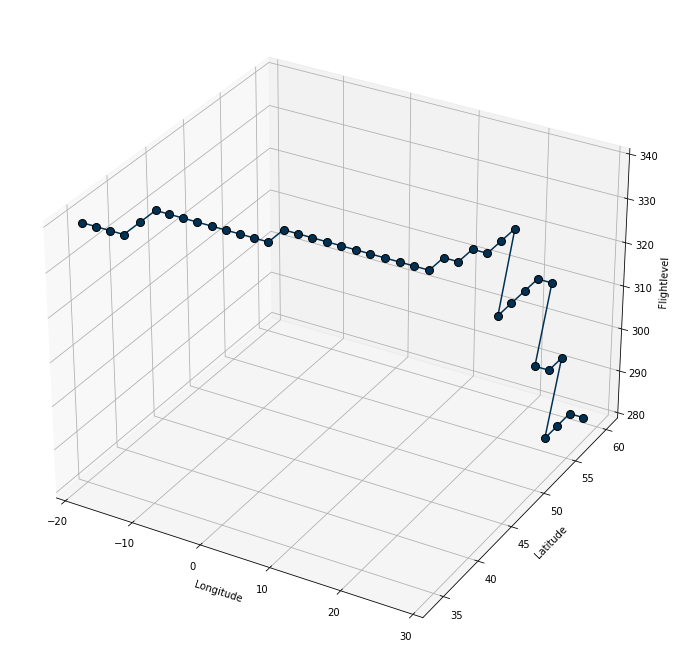

In [71]:
# %matplotlib notebook
flight_dict = flight_df.to_dict()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Flightlevel")
ax.plot(plot_x, plot_y, plot_z,color="#003153",mec='black', marker="o", ms=8)
plt.show()

# Circuit plot

In [193]:
# x_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "LONGITUDE"].to_numpy()
# y_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "LATITUDE"].to_numpy()
# merged_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 200) & (climate_df["TIME"] == "2018-06-23 06:00:00"), "MERGED"].to_numpy()

In [844]:
# fig, ax = plt.subplots(dpi=150)


# ax.plot(fl, tas, label= "TAS [kts]",color="#003153", mec="black", marker="o", ms=8)#[[0,0.1922,0.3255]]


# ax2 = ax.twinx()


# ax2.plot(fl, fuel, label="Fuel [kg/min]",color="#A42A04", mec='black', marker="o", ms=8)    


# ax2.invert_yaxis()

# ax.set_xlabel("Flight Level", fontsize=12)
# ax2.set_ylabel("Fuel Consumption rate",fontsize=12)
# ax.set_ylabel("True Air Speed",fontsize=12)

# fig.legend(bbox_to_anchor=(0.65, 0.88), loc=2)

In [845]:
# import matplotlib.ticker as ticker
# box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

# for c_1, i in enumerate(x_arr):
#     for c_2, j in enumerate(y_arr):
        
#         merged_plot = climate_df.loc[(climate_df["LEVEL11_24"] == 400) & (climate_df["TIME"] == "2018-06-23 06:00:00") & (climate_df["LONGITUDE"] == i) & (climate_df["LATITUDE"] == j), "MERGED"].to_numpy()
        
#         box_2d[c_1][c_2] = merged_plot[0]
                
# fig, ax = plt.subplots(dpi=250) 
# #sns.set(font_scale = 0.5)
# ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0)
# ax.set_ylabel("Longitude")
# ax.set_xlabel("Latitude")

    
# ax.xaxis.label.set_fontsize(12)
# ax.yaxis.label.set_fontsize(12)

# ax.xaxis.set_tick_params(labelsize=12)
# ax.yaxis.set_tick_params(labelsize=12)


# ax.set_yticks(ax.get_yticks()[::2])
# ax.legend
# plt.show()

In [819]:
oracle = QuantumCircuit(5)
oracle.initialize("00000",oracle.qubits)
good_state = Statevector.from_label('00000')
oracle.draw()


grover_op = GroverOperator(oracle)
grover_op.decompose().draw() #output='mpl'

global phase: π
         ┌────────────────────────┐┌───┐┌───┐          ┌───┐┌───┐     
state_0: ┤0                       ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤       │  ├───┤├───┤     
state_1: ┤1                       ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤       │  ├───┤├───┤     
state_2: ┤2 Initialize(0,0,0,0,0) ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤       │  ├───┤├───┤     
state_3: ┤3                       ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         │                        │├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
state_4: ┤4                       ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
         └────────────────────────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [567]:
# problem.grover_operator.oracle.decompose().draw()

In [ ]:
# #%matplotlib notebook
# flight_dict = flight_df.to_dict()

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# x_s = np.fromiter(flight_dict["start_longitudinal"].values(), dtype=float)
# y_s = np.fromiter(flight_dict["start_latitudinal"].values(), dtype=float)
# z_s = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)

# x_e = np.fromiter(flight_dict["end_longitudinal"].values(), dtype=float)
# y_e = np.fromiter(flight_dict["end_latitudinal"].values(), dtype=float)
# z_e = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)


# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# ax.set_zlabel("Flightlevel")

# ax.scatter(x_s, y_s, z_s,c="#003153")
# ax.scatter(x_e, y_e, z_e, c="#A42A04")

# #ax.invert_zaxis()

# plt.show()